# Project 2<br>Predict IMDb Rating

In [424]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
# Basic EDA, cleaning, and visualization modules

from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
import requests
# Webscraping 

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# Modeling

from directors_to_list import directors_list, remove_paren
from imdb_big_scrape import get_movie_links
from getting_info import get_movie_data
# Functions I made in corresponding .py files

import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Collect links using the 'get_movie_links' function
This function gathers data from IMDb using BeautifulSoup. Specifically, the function focuses on movies between 2018 and 2020 to be accurate prediting in the near future. There are over 20,000 results in the seach, which is plenty of information to acquire. The input to the function is how many pages is desired to scrape. Each page holds 100 movies. The function is liable to take some time, so I like the option to scrape less pages if desired.

In [182]:
movie_links = get_movie_links(1,1)
# Collect movie links
# 5  -->  500 links
# 10 --> 1000 links
# 20 --> 2000 links
# 40 --> 4000 links

In [183]:
len(movie_links)

57

## Step 2: Use the 'get_movie_data' function to collect desired data
This function also uses BeautifulSoup and takes the links collected using the get_movie_links function to return a list full of dictionaries holding information for each link passed into the function. After collecting the data, it's very easy to pass this into a Pandas DataFrame.

In [134]:
count = 0
movie_data_list = []
for link in movie_links:
    movie_data_list.append(get_movie_data(link))
    count += 1
    if count % 50 == 0:
        with open('IMDb_top_2000s.pickle', 'wb') as to_write:
            pickle.dump(movie_data_list, to_write)
# Create list with all movies from movie links

In [184]:
df2 = pd.DataFrame(movie_data_list)

In [237]:
movie_page_info = pd.DataFrame(movie_data_list)
# Turn data into a DataFrame for easy analysis

In [2]:
movies_8000 = pd.DataFrame(pd.read_pickle('IMDb_8000.pickle'))
# Reloaded pickled data after I reset the notebook
# IMDB_8000 contains 8000 movies between 2015 and 2020
# IMDb_top_movies supplements the data with top rated movies between 2010 and 2020
# IMDB_top_2000s supplements more top movies in the 2000s

In [185]:
movies_8070 = pd.concat([movies_8000,df,df2])

## Step 3: Dive into the data to further understand relationships

In [295]:
movies_df = movies_8070.copy()
movies_df.drop_duplicates(subset=['movie title'],inplace=True)
# Copy the original dataframe to mess with the data more freely

In [296]:
movies_df.set_index('movie title',inplace=True)
# Reset the index to be the Movie Title

In [297]:
movies_df_drop = movies_df.dropna(subset=['budget'])
# Drop movies without budget data

In [298]:
movies_df_drop.info()
# See what we're working with

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
Index: 2621 entries, Mulan to Dallas Buyers Club
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb rating           2461 non-null   float64
 1   imdb raters           2461 non-null   float64
 2   mpaa                  1547 non-null   object 
 3   genres                2620 non-null   object 
 4   director              2618 non-null   object 
 5   writer                2617 non-null   object 
 6   stars                 2560 non-null   object 
 7   country               2621 non-null   object 
 8   language              2621 non-null   object 
 9   release date          2430 non-null   object 
 10  budget                2621 non-null   float64
 11  opening weekend       898 non-null    float64
 12  gross usa             924 non-null    float64
 13  cumulative worldwide  1084 non-null   float64
 14  production companies  2446 non-null   object 

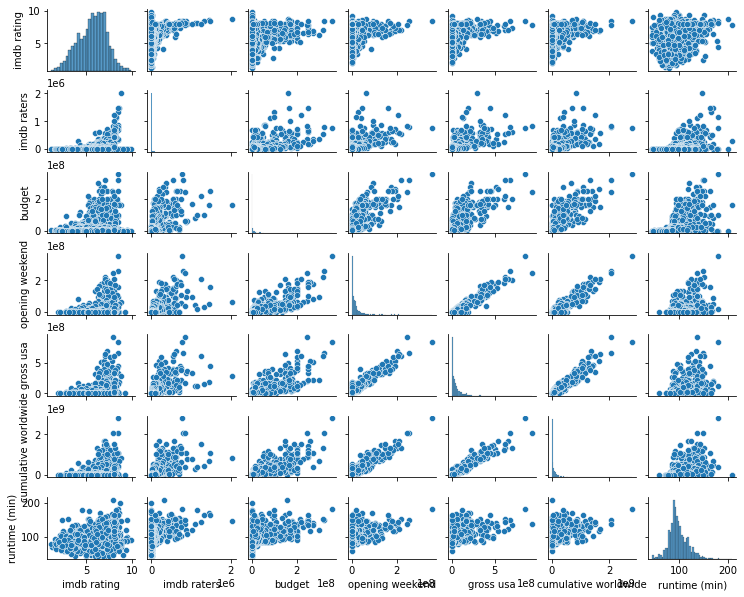

In [265]:
sns.pairplot(movies_df_drop, height=1.2, aspect=1.25);
# Visualize some relationships

## Step 4: Let's start cleaning the data to try and get an MVP

Drop rows with no rating, no MPAA, no release date, and no runtime

In [299]:
movies_df_drop['mpaa'].fillna('N/A', inplace=True)
# I don't want to lose titles with no MPAA, so let's fill in missing values with "Not Rated"

In [300]:
movie_drop2 = movies_df_drop[movies_df_drop['imdb rating'].notna()]
# Drop movies without a rating

In [301]:
movie_drop2 = movie_drop2[movie_drop2['imdb raters'] >= 1000]
# Remove movies with less than 1,000 raters for better validity in ratings

In [302]:
movie_drop2 = movie_drop2[movie_drop2['budget'] >= 1000]
# Remove movies with less than a $1,000 budget to focus model

In [303]:
movie_drop2 = movie_drop2[movie_drop2['runtime (min)'].notna()]
# Removes movies without Runtime data

Test out the new DataFrame

In [304]:
X, y = movie_drop2[['runtime (min)']], movie_drop2['imdb rating']

In [305]:
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.2479612431820406

Turned out small, but I think we can do better.<br>
Let's attempt to turn MPAA into dummy variables

In [306]:
mpaa_df = pd.get_dummies(movie_drop2['mpaa'])
# Get dummy variables for MPAA ratings

In [307]:
df_added_mpaa_dummies = pd.concat([movie_drop2,mpaa_df], axis=1)
# Add them to the rest of the data

In [308]:
df_added_mpaa_dummies['budget^2'] = df_added_mpaa_dummies['budget']**2
# Budget looks slightly quadratic, so let's try this

In [309]:
X, y = df_added_mpaa_dummies[['runtime (min)','budget^2']], df_added_mpaa_dummies['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)
# Increased the score by 0.002, but maybe it's better without the square

0.24950032669031663

In [310]:
df_added_mpaa_dummies.corr()
# The correlation is stronger for the budget column, so let's get rid of budget^2

imdb rating  imdb raters    budget  opening weekend  \
imdb rating              1.000000     0.509855  0.286878         0.247115   
imdb raters              0.509855     1.000000  0.553597         0.571700   
budget                   0.286878     0.553597  1.000000         0.757188   
opening weekend          0.247115     0.571700  0.757188         1.000000   
gross usa                0.345008     0.635539  0.741383         0.954724   
cumulative worldwide     0.347261     0.645443  0.797082         0.935499   
runtime (min)            0.497957     0.513785  0.466869         0.321842   
G                        0.069132     0.055045  0.142619         0.115491   
N/A                     -0.044202    -0.119693 -0.139016        -0.028280   
Not Rated               -0.202488    -0.137970 -0.165337        -0.060059   
PG                       0.090582    -0.056418  0.196465         0.090700   
PG-13                    0.086449     0.196209  0.288503         0.174392   
R                        0.008247    -0.003810 -0.244087        -0.233749   
TV-MA                   -0.066371    -0.064046 -0.066555        -0.034643   
Unrated                 -0.089344    -0.048751 -0.061616        -0.019796   
budget^2                 0.233005     0.513245  0.925388         0.793234   

                      gross usa  cumulative worldwide  runtime (min)  \
imdb rating            0.345008              0.347261       0.497957   
imdb raters            0.635539              0.645443       0.513785   
budget                 0.741383              0.797082       0.466869   
opening weekend        0.954724              0.935499       0.321842   
gross usa              1.000000              0.956501       0.336930   
cumulative worldwide   0.956501              1.000000       0.366404   
runtime (min)          0.336930              0.366404       1.000000   
G                      0.134686              0.121190      -0.029604   
N/A                   -0.030139             -0.063781      -0.186619   
Not Rated             -0.074142             -0.098894      -0.192634   
PG                     0.136243              0.146233      -0.079062   
PG-13                  0.155689              0.210070       0.217155   
R                     -0.244475             -0.258150       0.071359   
TV-MA                 -0.036803             -0.045084      -0.073162   
Unrated               -0.021075             -0.016964      -0.101121   
budget^2               0.746775              0.796705       0.395564   

                             G       N/A  Not Rated        PG     PG-13  \
imdb rating           0.069132 -0.044202  -0.202488  0.090582  0.086449   
imdb raters           0.055045 -0.119693  -0.137970 -0.056418  0.196209   
budget                0.142619 -0.139016  -0.165337  0.196465  0.288503   
opening weekend       0.115491 -0.028280  -0.060059  0.090700  0.174392   
gross usa             0.134686 -0.030139  -0.074142  0.136243  0.155689   
cumulative worldwide  0.121190 -0.063781  -0.098894  0.146233  0.210070   
runtime (min)        -0.029604 -0.186619  -0.192634 -0.079062  0.217155   
G                     1.000000 -0.013512  -0.015888 -0.022154 -0.040318   
N/A                  -0.013512  1.000000  -0.060859 -0.084860 -0.154440   
Not Rated            -0.015888 -0.060859   1.000000 -0.099786 -0.181603   
PG                   -0.022154 -0.084860  -0.099786  1.000000 -0.253223   
PG-13                -0.040318 -0.154440  -0.181603 -0.253223  1.000000   
R                    -0.049818 -0.190828  -0.224391 -0.312885 -0.569428   
TV-MA                -0.008717 -0.033392  -0.039265 -0.054750 -0.099642   
Unrated              -0.005592 -0.021420  -0.025188 -0.035121 -0.063918   
budget^2              0.131307 -0.083507  -0.099257  0.119262  0.260605   

                             R     TV-MA   Unrated  budget^2  
imdb rating           0.008247 -0.066371 -0.089344  0.233005  
imdb raters          -0.003810 -0.064046 -0.048751  0.513245  
budget               -

In [311]:
df_added_mpaa_dummies.drop(labels='budget^2',axis=1, inplace=True);

In [312]:
X, y = df_added_mpaa_dummies[['runtime (min)','budget']], df_added_mpaa_dummies['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)
# Definitely better without the square

0.25174505747695186

In [313]:
X, y = df_added_mpaa_dummies[['runtime (min)','budget','G','N/A','Not Rated','PG','PG-13','R','TV-MA','Unrated']], df_added_mpaa_dummies['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)
# Let's add the MPAA dummy variables

0.28586003108173474

The result was only a little bit better with the MPAA data. <br>
Let's try to add in genre dummy variables


In [314]:
df_genres_added = pd.Series(df_added_mpaa_dummies['genres'])
df_genres_added = pd.get_dummies(df_genres_added.apply(pd.Series).stack()).sum(level=0)
# Turns genres into dummy variables

In [315]:
df_genres_mpaa = pd.concat([df_added_mpaa_dummies, df_genres_added], axis=1)

In [316]:
df_genres_mpaa.corr()

imdb rating  imdb raters    budget  opening weekend  \
imdb rating              1.000000     0.509855  0.286878         0.247115   
imdb raters              0.509855     1.000000  0.553597         0.571700   
budget                   0.286878     0.553597  1.000000         0.757188   
opening weekend          0.247115     0.571700  0.757188         1.000000   
gross usa                0.345008     0.635539  0.741383         0.954724   
cumulative worldwide     0.347261     0.645443  0.797082         0.935499   
runtime (min)            0.497957     0.513785  0.466869         0.321842   
G                        0.069132     0.055045  0.142619         0.115491   
N/A                     -0.044202    -0.119693 -0.139016        -0.028280   
Not Rated               -0.202488    -0.137970 -0.165337        -0.060059   
PG                       0.090582    -0.056418  0.196465         0.090700   
PG-13                    0.086449     0.196209  0.288503         0.174392   
R                        0.008247    -0.003810 -0.244087        -0.233749   
TV-MA                   -0.066371    -0.064046 -0.066555        -0.034643   
Unrated                 -0.089344    -0.048751 -0.061616        -0.019796   
Action                  -0.073017     0.152221  0.347803         0.269956   
Adventure                0.078644     0.266378  0.613708         0.448497   
Animation                0.099562     0.008258  0.224305         0.172978   
Biography                0.233732     0.010979 -0.084053        -0.164483   
Comedy                   0.020496    -0.075199 -0.013734        -0.021393   
Crime                   -0.019843    -0.022936 -0.095313        -0.106347   
Drama                    0.240660    -0.049614 -0.260306        -0.319899   
Family                   0.065858    -0.025305  0.286838         0.156535   
Fantasy                  0.022171     0.039054  0.321652         0.169084   
History                  0.144835    -0.001115 -0.025314        -0.106495   
Horror                  -0.320388    -0.127444 -0.231585        -0.053810   
Music                    0.091128     0.020139 -0.046645        -0.036595   
Musical                  0.061580     0.014028  0.130097         0.111811   
Mystery                 -0.111933    -0.012018 -0.121484        -0.071557   
Romance                  0.060870    -0.074309 -0.116469        -0.104893   
Sci-Fi                  -0.047028     0.234154  0.330281         0.358012   
Sport                    0.116225    -0.026478 -0.039808        -0.067444   
Thriller                -0.229686    -0.038267 -0.150881        -0.093245   
War                      0.081379     0.002671 -0.008512        -0.067254   
Western                  0.010933     0.040042 -0.020212        -0.046584   

                      gross usa  cumulative worldwide  runtime (min)  \
imdb rating            0.345008              0.347261       0.497957   
imdb raters            0.635539              0.645443       0.513785   
budget                 0.741383              0.797082       0.466869   
opening weekend        0.954724              0.935499       0.321842   
gross usa              1.000000              0.956501       0.336930   
cumulative worldwide   0.956501              1.000000       0.366404   
runtime (min)          0.336930              0.366404       1.000000   
G                      0.134686              0.121190      -0.029604   
N/A                   -0.030139             -0.063781      -0.186619   
Not Rated             -0.074142             -0.098894      -0.192634   
PG                     0.136243              0.146233      -0.079062   
PG-13                  0.155689              0.210070       0.217155   
R                     -0.244475             -0.258150       0.071359   
TV-MA                 -0.036803             -0.045084      -0.073162   
Unrated               -0.021075             -0.016964      -0.101121   
Action                 0.226754              0.218774       0.120699   
Adventure              0.

In [317]:
df_genres_mpaa.drop(labels='Western',axis=1,inplace=True)
# I would say that it's safe to remove the Western feature based on it's very low correlation

In [318]:
X, y = df_genres_mpaa[['runtime (min)','budget','G','N/A','Not Rated','PG','PG-13','R','TV-MA','Unrated','Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','History','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War']], df_genres_mpaa['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)
# This test jumped up almost a whole point from the last test, which is promising

0.3747067062859758

Simple initial tests worked fairly well to get an MVP.<br>
Now I'd like to try and sort out Director, Writer, and Stars columns to create<br>
some more intricate measures of success

In [319]:
empty_dir = movie_drop2[movie_drop2['director']==''].index.values.tolist()
# I noticed some empty director entries, so I will fill these manually

In [320]:
dir_fill = [
    'Peter Ramsey, Bob Persichetti, Rodney Rothman',
    'Ron Clements, John Musker',
    'Byron Howard, Rich Moore',
    'Pierre Coffin, Chris Renaud',
    'Scott Sava, Tony Bancroft',
    'Charlie Bean, Bob Logan, Paul Fisher',
    'Vincent Kesteloot, Ben Stassen',
    'Mark Columbus, Shadae Lamar Smith',
    'Michael Rousselet, Jon Salmon'
    ]
# Got the directors corresponding to the movies

In [321]:
for num, movie in enumerate(empty_dir):
    movie_drop2['director'][movie] = dir_fill[num]
# Run through the empty directors and fill with added info

In [322]:
movie_drop2['director'] = movie_drop2['director'].apply(lambda x: directors_list(x))
# Turns directors into a list to fix some inconsistencies

In [323]:
movie_drop2['director'] = movie_drop2['director'].apply(lambda x: remove_paren(x))
# Remove parentheses in director columns

In [326]:
df_dir_exploded = movie_drop2.explode('director')
# Explode out directors to report on their relevance

In [327]:
df_dir_exploded.groupby('director').mean()['imdb rating'].sort_values(ascending=False)[:-100:-1]
print('Min: {}'.format(df_dir_exploded.groupby('director').mean()['imdb rating'].sort_values(ascending=False).min()))
print('Max: {}'.format(df_dir_exploded.groupby('director').mean()['imdb rating'].sort_values(ascending=False).max()))

# Look at each director's mean rating

Min: 1.3
Max: 9.4


Now I must figure out how to use these mean ratings to organize the directors and include it in the model

In [328]:
mean_dir_rating = pd.DataFrame(df_dir_exploded.groupby('director').mean()['imdb rating'].sort_values(ascending=False))
# Group the directors and sort by the mean of their ratings

In [329]:
mean_dir_rating['rating bins'] = pd.cut(x=mean_dir_rating['imdb rating'], bins=[0,5,5.5,6,6.5,7,8,10], labels=['0.0-5.0','5.0-5.5','5.5-6.0','6.0-6.5','6.5-7.0','7.0-8.0','8.0-10.0'])
# Create bins to categorize the directors

In [330]:
mean_dir_rating['rating bins'].value_counts()
# I used this cell a bit to mess with the bins and try to have equal counts
# Additionally, I pulled more data to get insight into the higher ratings

6.0-6.5     181
6.5-7.0     156
5.5-6.0     154
7.0-8.0     153
0.0-5.0     147
5.0-5.5     129
8.0-10.0     29
Name: rating bins, dtype: int64

In [394]:
def dir_rating_column(dir_list):
    for director in dir_list:
        rating = 0
        if mean_dir_rating.loc[director]["imdb rating"] > rating:
            rating = mean_dir_rating.loc[director]["imdb rating"]
        return rating
# Create a function to make this new column
# I decided to just use the mean rating rather than bins

In [398]:
movie_drop2['mean director rating'] = movie_drop2['director'].apply(lambda x:dir_rating_column(x))
# Utilize that function

In [408]:
df_genres_mpaa['mean director rating'] = movie_drop2['mean director rating']
# Add that column to our previously tampered df

In [421]:
X, y = df_genres_mpaa[['runtime (min)','budget','G','N/A','Not Rated','PG','PG-13','R','TV-MA','Unrated','Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','History','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','mean director rating']], df_genres_mpaa['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)
# The result makes a lot of sense because all of the data is fitting perfectly
# Now we have to test/train/split to truly validate our model

0.9139265967644036

## Step 5: Train / Validation / Test
Our model is looking decent, but that 0.91 R^2 valued is making me hestitant to move forward. I believe the Mean Director Rating is making this model too accurate and it's time to split up the data and undergo more rigorous testing

In [416]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=15)
# Set up the data
# Our X and y values have already been established earlier in this notebook

In [417]:
#Set up the 3 models
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [418]:
# validate
lr.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lr.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.890
Ridge Regression val R^2: 0.890
Degree 2 polynomial regression val R^2: 0.214


After splitting up our data, it seems like the model is doing a great job with both Linear Regression and Ridge. I do think we should do some more rigorous testing

In [422]:
X, y = df_genres_mpaa[['runtime (min)','budget','G','N/A','Not Rated','PG','PG-13','R','TV-MA','Unrated','Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','History','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','mean director rating']], df_genres_mpaa['imdb rating']
# Reset X and y

In [425]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing
X, y = np.array(X), np.array(y)

In [434]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 20)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.8814709296517753, 0.9303312497217311, 0.9062733111186337, 0.8644502349418732, 0.925144019802952]
Ridge scores:  [0.881800246185846, 0.930333110647798, 0.9061922191347795, 0.8643573671003719, 0.9251617076053505] 

Simple mean cv r^2: 0.902 +- 0.025
Ridge mean cv r^2: 0.902 +- 0.025


In [440]:
actor_set = set()
for actors in movie_drop2['stars'].tolist():
    for actor in actors:
        actor_set.add(actor)


In [444]:
df_genres_mpaa.corr()

{&#39;Daniel Radcliffe&#39;,
 &#39;Dax Shepard&#39;,
 &#39;Robert Englund&#39;,
 &#39;Angela Kerecz&#39;,
 &#39;Scott Shepherd&#39;,
 &#39;Alison Brie&#39;,
 &#39;Louis Mandylor&#39;,
 &#39;Djimon Hounsou&#39;,
 &#39;Leem Lubany&#39;,
 &#39;Adam Devine&#39;,
 &#39;Ice Cube&#39;,
 &#39;Jessie T. Usher&#39;,
 &#39;Stephen Conroy&#39;,
 &#39;Adolfo Alvarez&#39;,
 &#39;Rob Franco&#39;,
 &#39;Jacqueline Duprey&#39;,
 &#39;Samara Weaving&#39;,
 &#39;Kane Hodder&#39;,
 &#39;April Hartman&#39;,
 &#39;Helen Hunt&#39;,
 &#39;Vince Vaughn&#39;,
 &#39;Salma Hayek&#39;,
 &#39;Mikey Averill&#39;,
 &#39;Jared Leto&#39;,
 &#39;Ruth Negga&#39;,
 &#39;Jon Øigarden&#39;,
 &#39;Wes Bentley&#39;,
 &#39;Babou Ceesay&#39;,
 &#39;Zach Woods&#39;,
 &#39;Brooke Adams&#39;,
 &#39;Tommy Lee Jones&#39;,
 &#39;Peter Facinelli&#39;,
 &#39;Thomas Lennon&#39;,
 &#39;Adrian Grenier&#39;,
 &#39;Madison Wolfe&#39;,
 &#39;Gary Cole&#39;,
 &#39;Liam Neeson&#39;,
 &#39;Levi Miller&#39;,
 &#39;Bruce Dern&#39;,
 &#39;Donald S